In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from pprint import pprint
from scipy.signal import find_peaks

In [6]:
data_dir = r"C:\Users\yrliu98\Desktop\20250424_2step_autobot"

xy_files = list(Path(data_dir).glob("2D_PYSK_2STEP_4*.xy"))

xy_files.append(
    Path(
        r"C:\Users\yrliu98\Desktop\2025-04-03_Cyrene_test\cyrene_ACN_01_001_exported.xy"
    )
)

# to_exclude = [1, 2, 3, 5, 6, 7]

# for i in sorted(to_exclude, reverse=True):
#     xy_files.pop(i)

pprint(xy_files)

[WindowsPath('C:/Users/yrliu98/Desktop/20250424_2step_autobot/2D_PYSK_2STEP_4_A01_000_exported.xy'),
 WindowsPath('C:/Users/yrliu98/Desktop/20250424_2step_autobot/2D_PYSK_2STEP_4_A02_000_exported.xy'),
 WindowsPath('C:/Users/yrliu98/Desktop/20250424_2step_autobot/2D_PYSK_2STEP_4_A03_000_exported.xy'),
 WindowsPath('C:/Users/yrliu98/Desktop/2025-04-03_Cyrene_test/cyrene_ACN_01_001_exported.xy')]


In [7]:
Co_K_alpha = 1.7902
Cu_K_alpha = 1.5406

dfs = []
for xy_file in xy_files:
    df = pd.read_csv(xy_file, sep=" ", skiprows=1, names=["2theta_Co", "int"])
    df = df.assign(**{"2theta_Cu": lambda x: x["2theta_Co"] * Cu_K_alpha / Co_K_alpha})

    df = df[(df["2theta_Cu"] > 5) & (df["2theta_Cu"] < 50.5)]

    peaks, _ = find_peaks(df["int"], prominence=[0.6, None])

    dfs.append(
        {"name": xy_file.stem.replace("_exported", ""), **df.to_dict(orient="list")}
    )

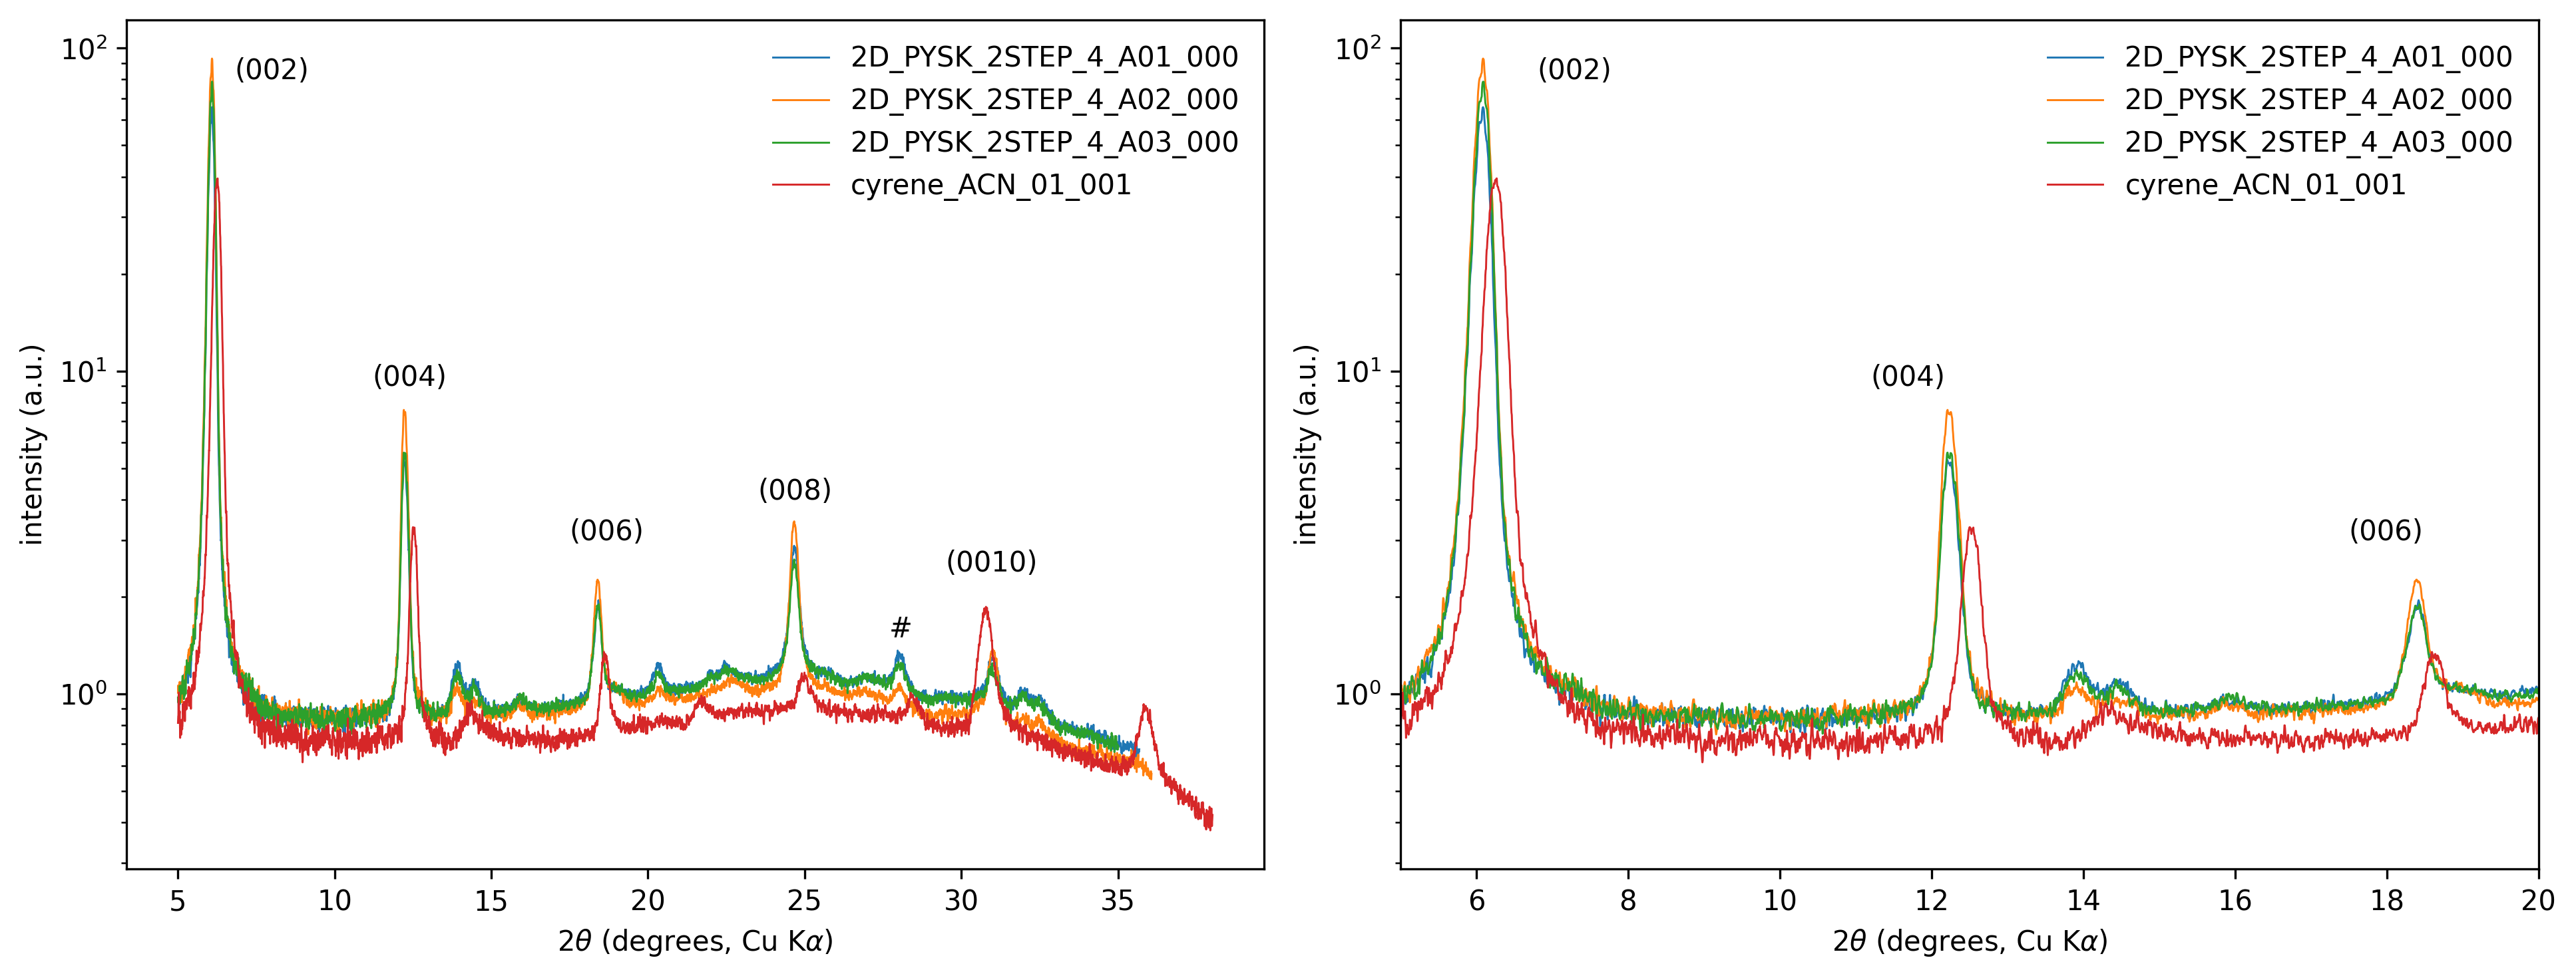

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300, layout="tight")

for ax in axs:
    for df in dfs:
        ax.plot(df["2theta_Cu"], df["int"], label=df["name"], lw=0.7)

    handles, labels = ax.get_legend_handles_labels()
    order = []
    if len(order) == len(dfs):
        ax.legend(
            [handles[idx] for idx in order],
            [labels[idx] for idx in order],
            frameon=False,
        )
    else:
        ax.legend(frameon=False)

    ax.set_yscale("log")
    ax.set_xlabel("$2\\theta$ (degrees, Cu K$\\alpha$)")
    ax.set_ylabel("intensity (a.u.)")

    ax.text(6.8, 80, "(002)", clip_on=True)
    ax.text(11.2, 9, "(004)", clip_on=True)
    ax.text(17.5, 3, "(006)", clip_on=True)
    ax.text(23.5, 4, "(008)", clip_on=True)
    ax.text(29.5, 2.4, "(0010)", clip_on=True)

    ax.text(27.7, 1.5, "#", clip_on=True)

axs[1].set_xlim(5, 20)

fig.savefig(Path(data_dir, "compare_1step_plot.jpg"))

In [2]:
from pathlib import Path

data_dir = Path(r"G:\My Drive\LPS\20250904_LPS_pre_5")

merge_raw_files = list(data_dir.glob("**/*_m.raw"))

# rename the files from *_m.raw to *_merge.raw
for raw_file in merge_raw_files:
    new_name = raw_file.stem.replace("_m", "_merge") + raw_file.suffix
    raw_file.rename(raw_file.with_name(new_name))
    print(f"Renamed {raw_file.name} to {new_name}")

Renamed LPS_pre5_1_A01_m.raw to LPS_pre5_1_A01_merge.raw
Renamed LPS_pre5_1_A02_m.raw to LPS_pre5_1_A02_merge.raw
Renamed LPS_pre5_1_A03_m.raw to LPS_pre5_1_A03_merge.raw
Renamed LPS_pre5_1_A04_m.raw to LPS_pre5_1_A04_merge.raw
Renamed LPS_pre5_1_B01_m.raw to LPS_pre5_1_B01_merge.raw
Renamed LPS_pre5_1_B02_m.raw to LPS_pre5_1_B02_merge.raw
Renamed LPS_pre5_1_B03_m.raw to LPS_pre5_1_B03_merge.raw
Renamed LPS_pre5_1_B04_m.raw to LPS_pre5_1_B04_merge.raw


In [3]:
import xylib
from pathlib import Path

data_dir = Path(r"G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test")

# merge_raw_files = list(data_dir.glob("**/*_merge.raw"))


merge_raw_files = list(data_dir.glob("**/*.raw"))

# remove files that have "_merge" in the name
merge_raw_files = [f for f in merge_raw_files if "_merge" not in f.stem]


def export_metadata(f, meta):
    for i in range(meta.size()):
        key = meta.get_key(i)
        value = meta.get(key)
        f.write("# %s: %s\n" % (key, value.replace("\n", "\n#\t")))


def convert_raw_to_xy(raw_file, filetype="", store_meta=True):
    d = xylib.load_file(str(raw_file), filetype)
    # name_frags = raw_file.stem.split("_")
    # output_file = raw_file.with_name(f"rapha_cold_anneal_{name_frags[-2]}_merge.xy")
    output_file = raw_file.with_suffix(".xy")
    with open(output_file, "w") as f:
        f.write("# exported by xylib from a %s file\n" % d.fi.name)
        # output the file-level meta-info
        if store_meta and d.meta.size():
            export_metadata(f, d.meta)
            f.write("\n")
        nb = d.get_block_count()
        for i in range(nb):
            block = d.get_block(i)
            if nb > 1 or block.get_name():
                f.write("\n### block #%d %s\n" % (i, block.get_name()))
            if store_meta:
                export_metadata(f, block.meta)

            ncol = block.get_column_count()
            # column 0 is pseudo-column with point indices, we skip it
            col_names = [
                block.get_column(k).get_name() or ("column_%d" % k)
                for k in range(1, ncol + 1)
            ]
            f.write("# " + "\t".join(col_names) + "\n")
            nrow = block.get_point_count()
            for j in range(nrow):
                values = [
                    "%.6f" % block.get_column(k).get_value(j)
                    for k in range(1, ncol + 1)
                ]
                f.write("\t".join(values) + "\n")

    return output_file


xy_files = []
for raw_file in merge_raw_files:
    print(f"Converting {raw_file} to .xy")
    xy_files.append(convert_raw_to_xy(raw_file))

print(xy_files)

Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_A01.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_A02.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_A03.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_A04.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_B01.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_B02.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_B03.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_1\LPS_pre5_1_B04.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_2\LPS_pre5_2_A01.raw to .xy
Converting G:\My Drive\LPS\20250904_LPS_pre_5\XRD_test\20250905_LPS_pre5_2\LPS_pre5_2_A02.r

In [4]:
import pandas as pd

Co_K_alpha = 1.7902
Cu_K_alpha = 1.5406

dfs = []
for xy_file in xy_files:
    two_theta_Co_col = f"2theta_Co_{xy_file.stem}"
    int_col = f"int_{xy_file.stem}"

    df = pd.read_csv(xy_file, sep="\t", comment="#", names=[two_theta_Co_col, int_col])
    df = df.assign(
        **{"2theta_Cu": lambda x: x[two_theta_Co_col] * Cu_K_alpha / Co_K_alpha}
    )
    df = df.set_index("2theta_Cu")
    df = df[(df.index > 4) & (df.index < 50.5)]
    # peaks, _ = find_peaks(df[int_col], prominence=[0.6, None])
    dfs.append(df)

df = pd.concat(dfs, axis=1)

ValueError: Unknown label for S_MeO_pre3_1_A01

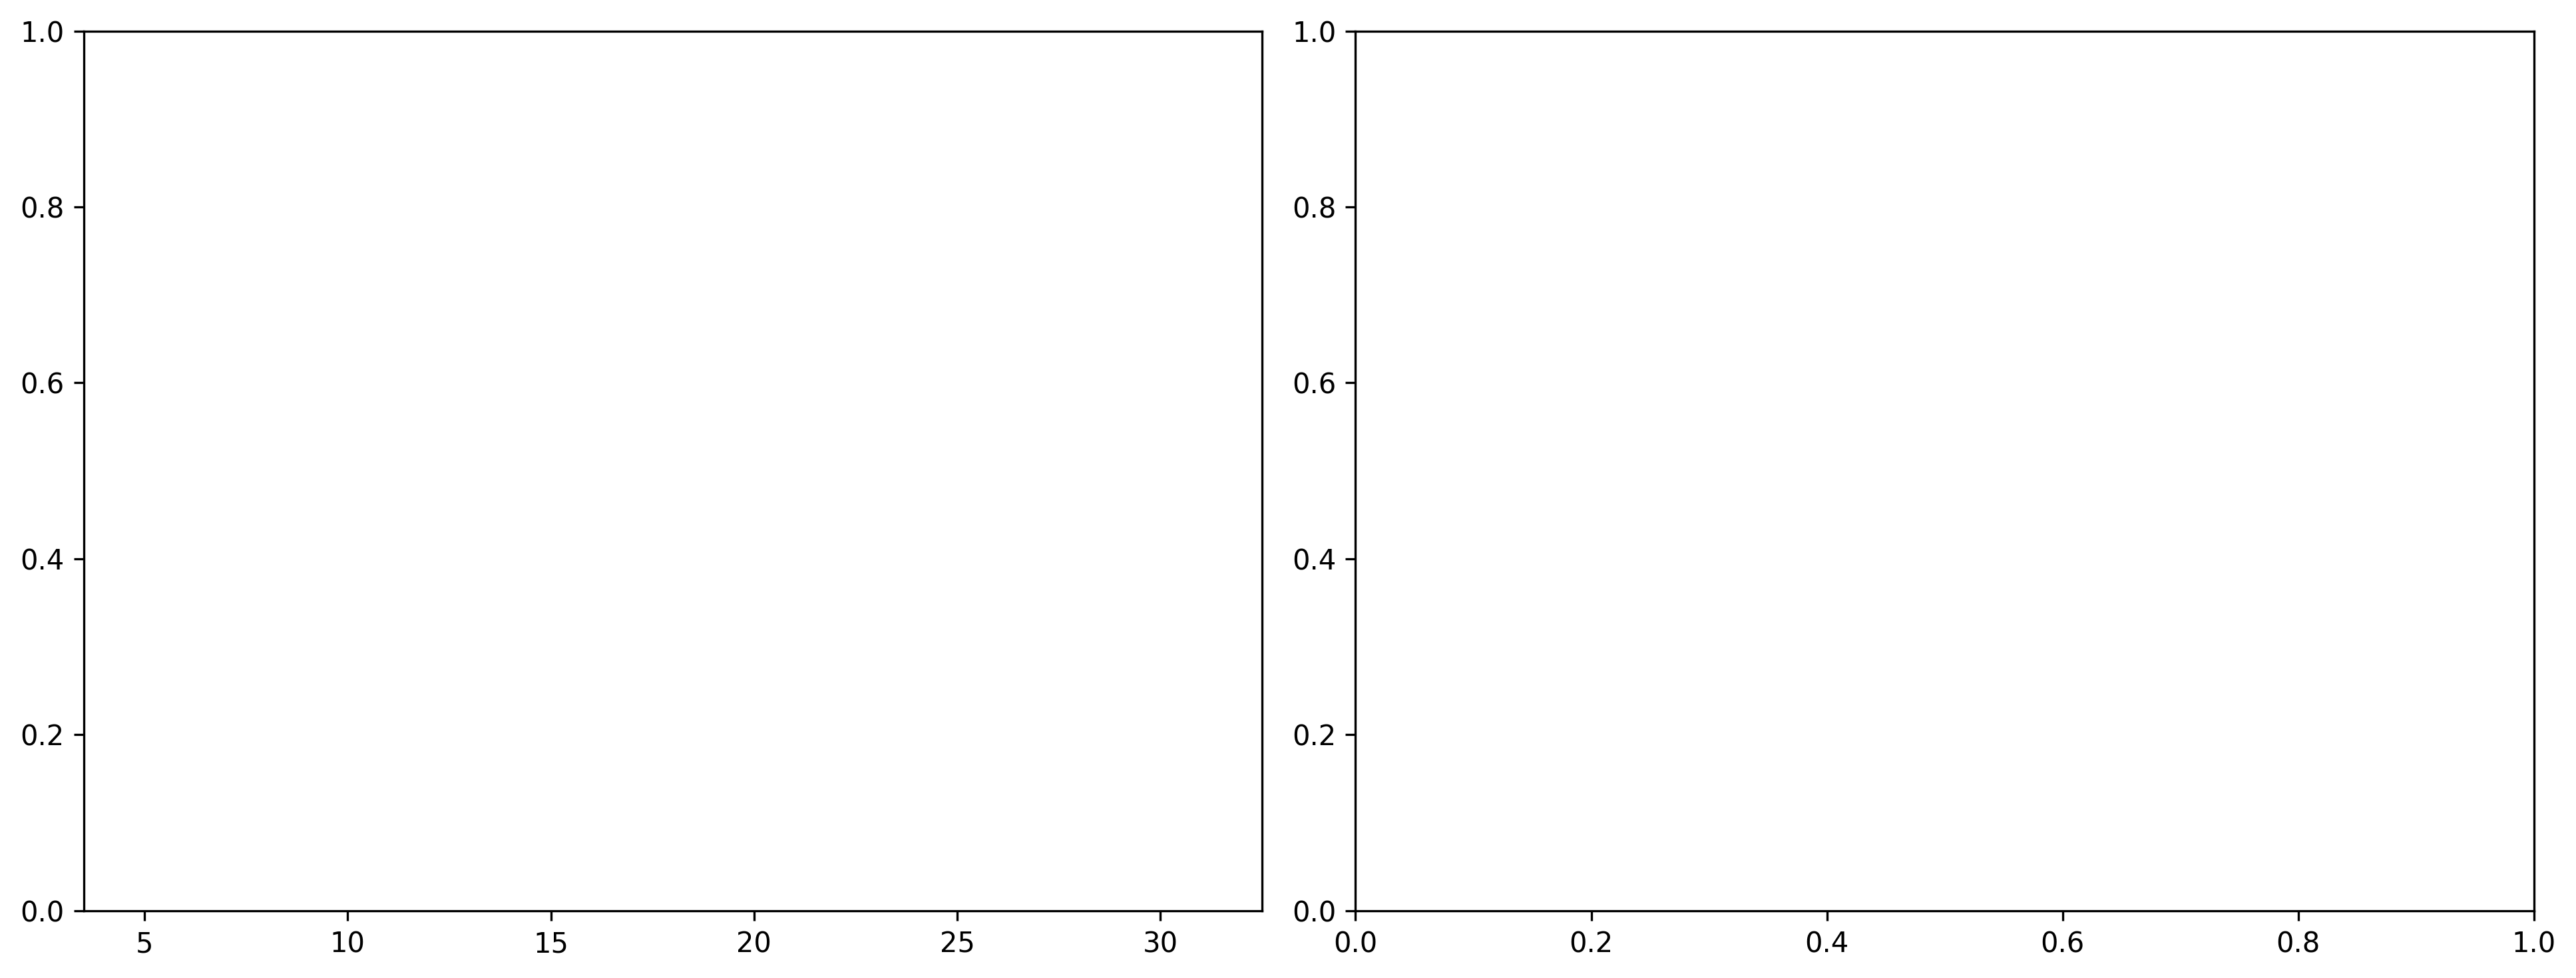

In [7]:
def get_label(name):
    name = name.replace("int_", "").replace("_merge", "")

    if name.startswith("S_MeO_A"):
        return name.replace("S_MeO_A", "GB")

    if name.startswith("S_MeO_B"):
        return name.replace("S_MeO_B", "Robot")

    raise ValueError(f"Unknown label for {name}")


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300, layout="tight")
axs[0].set_xlim(3.5, 32.5)

for ax in axs:
    for intensity_col in [col for col in df.columns if col.startswith("int_")]:
        df_to_plot = df[[intensity_col]].dropna()
        label = get_label(intensity_col)
        ax.plot(
            df_to_plot.index,
            df_to_plot[intensity_col],
            label=get_label(intensity_col),
            lw=1,
            linestyle="-" if label.startswith("GB") else ":",
        )

    ax.set_yscale("log")
    ax.set_xlabel("$2\\theta$ (degrees, Cu K$\\alpha$)")
    ax.set_ylabel("intensity (a.u.)")
    ax.legend()

axs[1].set_xlim(4, 17)

fig.savefig(Path(data_dir, f"{data_dir.stem}.jpg"))

In [30]:
from pathlib import Path

data_dir = Path(r"G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD")

xy_files = list(data_dir.glob("**/*merge.xy"))

print(xy_files)

[WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_A01_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_A02_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_A03_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_B01_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_B02_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_2/S_MeO_pre4_2_B03_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_3/S_MeO_pre_4_3_A01_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_3/S_MeO_pre_4_3_A02_merge.xy'), WindowsPath('G:/My Drive/LPS/20250819_S_MeOMBAI_prestudy_4/XRD/20250822_S_MeO_3/S_MeO_pre_4_3_A03_merge.xy'), WindowsPath('G:

Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_A01_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_A02_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_A03_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_B01_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_B02_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_2\S_MeO_pre4_2_B03_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_3\S_MeO_pre_4_3_A01_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\20250822_S_MeO_3\S_MeO_pre_4_3_A02_merge.xy to 2theta_Cu
Converting G:\My Drive\LPS\20250819_S_MeOMBAI_prestudy_4\XRD\2

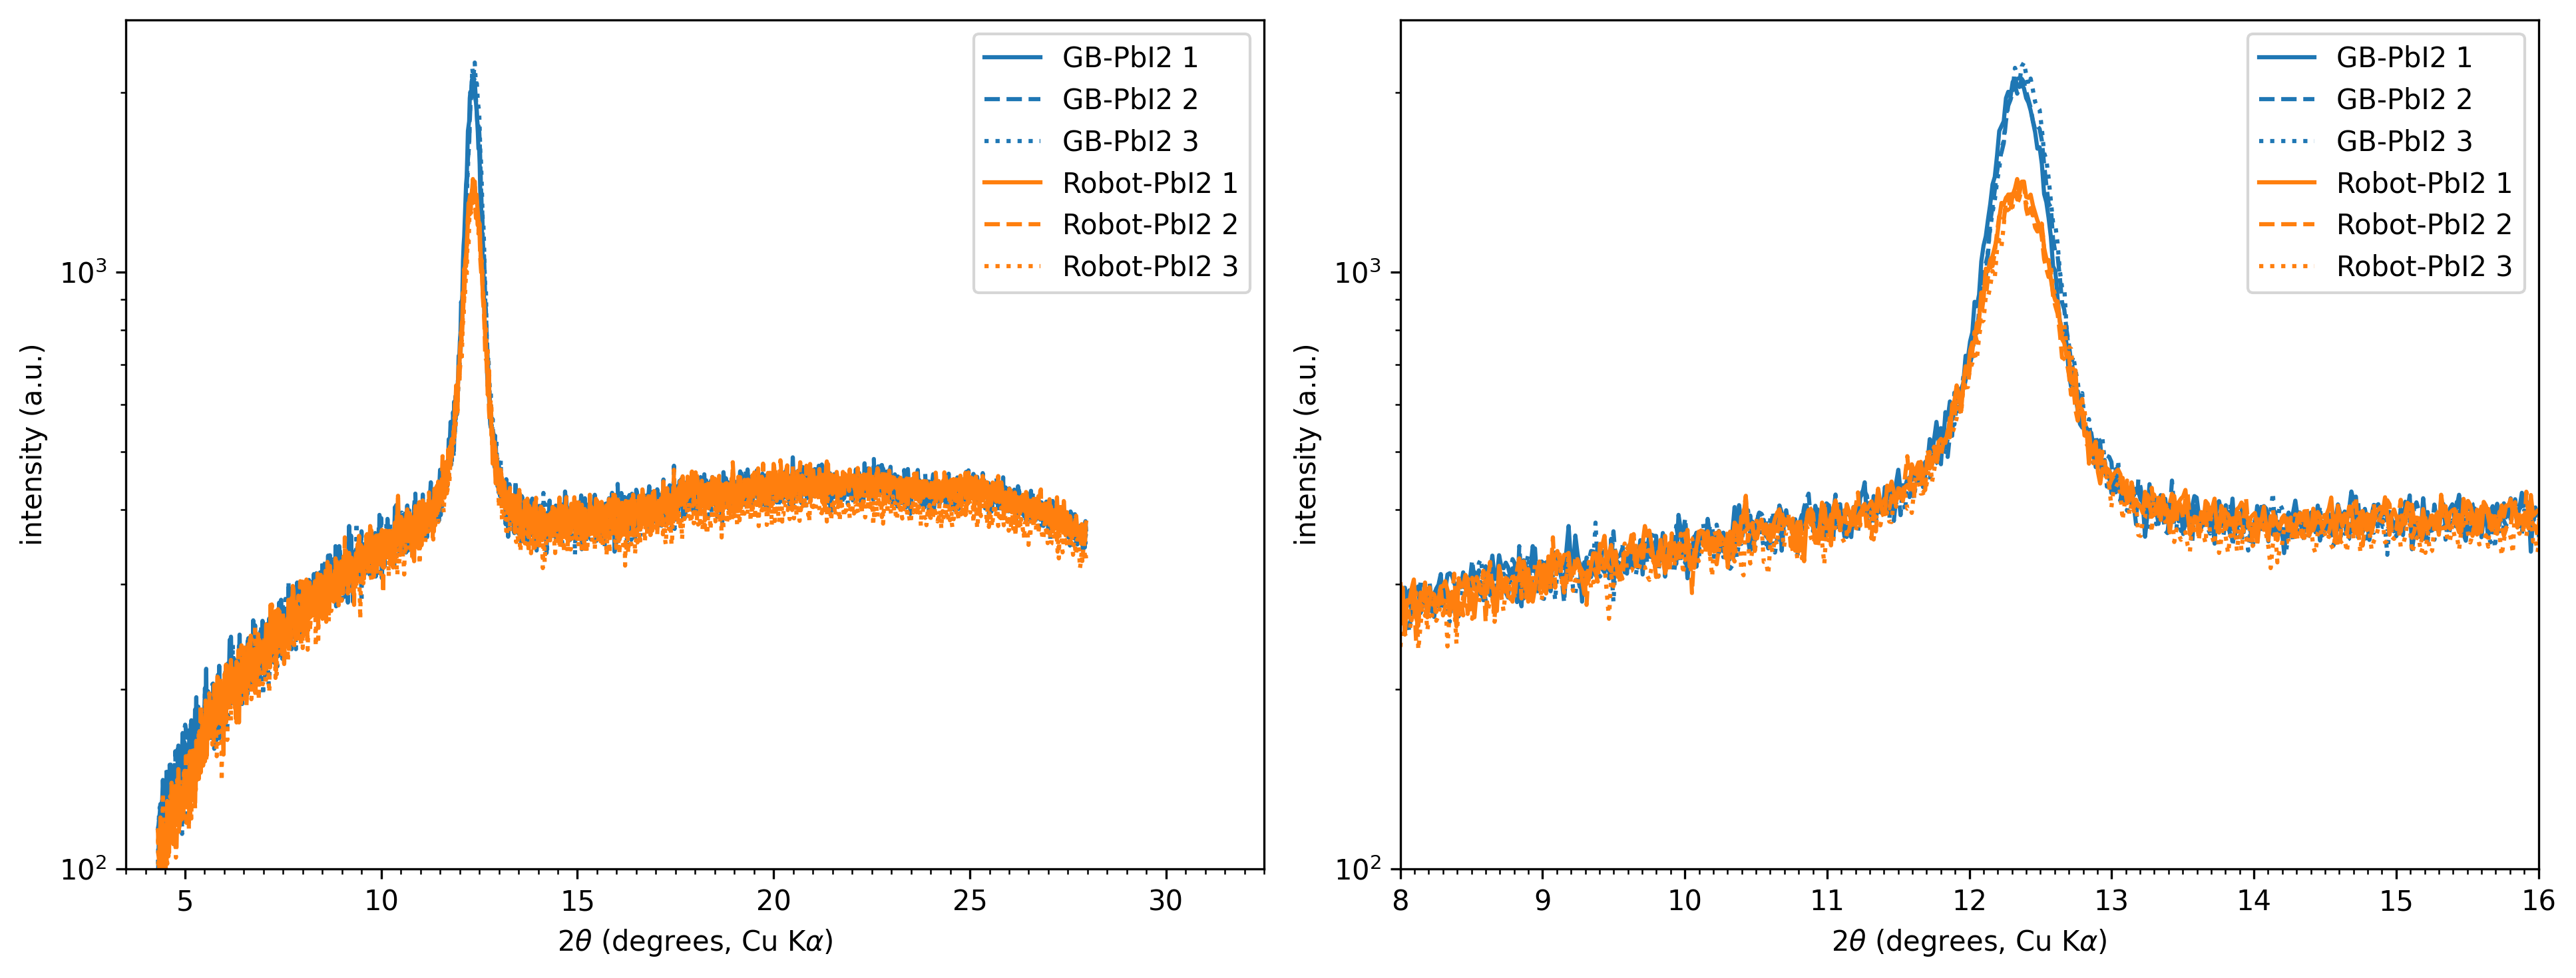

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


def get_label(filename):
    mapping = {
        "S_MeO_pre4_1_A01": "GB 1",
        "S_MeO_pre4_1_A02": "GB 2",
        "S_MeO_pre4_1_A03": "GB 3",
        "S_MeO_pre4_1_B01": "GB-PMMA 1",
        "S_MeO_pre4_1_B02": "GB-PMMA 2",
        "S_MeO_pre4_1_B03": "GB-PMMA 3",
        "S_MeO_pre4_2_A01": "Robot 1",
        "S_MeO_pre4_2_A02": "Robot 2",
        "S_MeO_pre4_2_A03": "Robot 3",
        "S_MeO_pre4_2_B01": "Robot-PMMA 1",
        "S_MeO_pre4_2_B02": "Robot-PMMA 2",
        "S_MeO_pre4_2_B03": "Robot-PMMA 3",
        "S_MeO_pre_4_3_A01": "GB-PbI2 1",
        "S_MeO_pre_4_3_A02": "GB-PbI2 2",
        "S_MeO_pre_4_3_A03": "GB-PbI2 3",
        "S_MeO_pre_4_3_B01": "Robot-PbI2 1",
        "S_MeO_pre_4_3_B02": "Robot-PbI2 2",
        "S_MeO_pre_4_3_B03": "Robot-PbI2 3",
    }
    try:
        return "int_" + mapping[filename.removeprefix("int_").removesuffix("_merge")]
    except KeyError:
        print(f"Warning: no label mapping for {filename}")
        return filename


from plot_helper import get_linestyle_factory, get_color_factory


def add_peak_label(
    ax, df, x, text, x_range=1.0, y_offset=None, log_scale=None, fontdict=None
):
    """
    Add a text label to the axis at the given x position.
    The y position is set to the max y value within ±x_range of x across all int_ columns, plus y_offset.

    Parameters:
    - log_scale: If True, treats y_offset as a multiplicative factor for log scale.
                 If False, treats y_offset as an additive offset for linear scale.
    """

    if log_scale is None:
        log_scale = ax.get_yscale() == "log"

    if y_offset is None:
        y_offset = 1.2 if log_scale else 20

    # Filter rows within the x range
    mask = (df.index > (x - x_range)) & (df.index < (x + x_range))
    if mask.any():
        # Get all intensity columns (starting with "int_")
        int_cols = [col for col in df.columns if col.startswith("int_")]
        # Find the maximum y value across all intensity columns within the range
        y_max = df.loc[mask, int_cols].max().max()

        if log_scale:
            # For log scale, multiply by offset factor to get consistent visual spacing
            y_text = y_max * y_offset
        else:
            # For linear scale, add offset
            y_text = y_max + y_offset

        ax.text(
            x, y_text, text, clip_on=True, fontdict=fontdict
        )  # Use fontdict if provided
    else:
        fallback_y = y_offset if not log_scale else y_offset
        ax.text(
            x, fallback_y, text, clip_on=True, fontdict=fontdict
        )  # fallback if no data in range


Co_K_alpha = 1.7902
Cu_K_alpha = 1.5406

dfs = []
for xy_file in xy_files:
    two_theta_Co_col = f"2theta_Co_{xy_file.stem}"
    int_col = f"int_{xy_file.stem}"

    df = pd.read_csv(xy_file, sep="\t", comment="#", names=[two_theta_Co_col, int_col])

    print(f"Converting {xy_file} to 2theta_Cu")
    df = df.assign(
        **{"2theta_Cu": lambda x: x[two_theta_Co_col] * Cu_K_alpha / Co_K_alpha}
    )
    df = df.set_index("2theta_Cu")
    df = df[(df.index > 4) & (df.index < 50.5)]
    # peaks, _ = find_peaks(df[int_col], prominence=[0.6, None])
    # df[int_col] = gaussian_filter1d(df[int_col], sigma=10)

    # remove baseline
    # df[int_col] = df[int_col] - 1200
    dfs.append(df)

df = pd.concat(dfs, axis=1)

df = df.rename(columns=get_label)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300, layout="tight")
axs[0].set_xlim(3.5, 32.5)

print(df.columns)

colums_to_plot = [
    # "GB 1",
    # "GB 2",
    # "GB 3",
    # "Robot 1",
    # "Robot 2",
    # "Robot 3",
    # "GB-PMMA 1",
    # "GB-PMMA 2",
    # "GB-PMMA 3",
    # "Robot-PMMA 1",
    # "Robot-PMMA 2",
    # "Robot-PMMA 3",
    "GB-PbI2 1",
    "GB-PbI2 2",
    "GB-PbI2 3",
    "Robot-PbI2 1",
    "Robot-PbI2 2",
    "Robot-PbI2 3",
]

index_offsets = {
    "GB 1": 0.0,
    "GB 2": 0.0,
    "GB 3": 0.0,
    "Robot 1": 0.0,
    "Robot 2": 0.0,
    "Robot 3": 0.0,
    "GB-MBAI 1": 0.0,
    "GB-MBAI 2": 0.0,
    "GB-MBAI 3": 0.0,
    "Robot-MBAI 1": 0.0,
    "Robot-MBAI 2": 0.0,
    "Robot-MBAI 3": 0.0,
    "Robot-dispense  80 uL/s": 0.0,
    "Robot-dispense 100 uL/s": 0.0,
    "Robot-dispense 160 uL/s": 0.0,
    "Robot-dispense 190 uL/s": 0.0,
    "R-disp 220 uL/s": 0.0,
}

if colums_to_plot:
    intensity_cols = [
        col
        for col in sorted(df.columns)
        if col.startswith("int_") and col.removeprefix("int_") in colums_to_plot
    ]

else:
    intensity_cols = [col for col in sorted(df.columns) if col.startswith("int_")]

print(intensity_cols)

import numpy as np

for ax in axs:
    get_color = get_color_factory()
    # get_linestyle = lambda x: None
    get_linestyle = get_linestyle_factory()
    for intensity_col in intensity_cols:
        df_to_plot = df[[intensity_col]].dropna()
        ax.plot(
            df_to_plot.index + index_offsets.get(intensity_col.removeprefix("int_"), 0),
            df_to_plot[intensity_col],
            label=intensity_col.removeprefix("int_"),
            # lw=0.7,
            linestyle=get_linestyle(intensity_col),
            color=get_color(intensity_col),
        )

    ax.set_yscale("log")
    ax.set_xlabel("$2\\theta$ (degrees, Cu K$\\alpha$)")
    ax.set_ylabel("intensity (a.u.)")
    ax.set_ylim(100, ax.get_ylim()[1])  # Set y-limits to start from 0.1
    ax.legend()

    # handles, labels = ax.get_legend_handles_labels()
    # order = sorted(range(len(labels)), key=lambda i: (i % 3))
    # legend = ax.legend(
    #     ncols=3,
    #     handles=[handles[idx] for idx in order],
    #     labels=[labels[idx] for idx in order],
    #     framealpha=0,
    #     # prop={"size": 4},
    # )

    ax.minorticks_on()
    from matplotlib.ticker import AutoMinorLocator

    minor_locator = AutoMinorLocator(10)
    ax.xaxis.set_minor_locator(minor_locator)

    # ax.grid(visible=True, which="major", axis="x", color="gray", linestyle="-", linewidth=0.3)
    # ax.grid(visible=True, which="minor", axis="x", color="gray", linestyle="-", linewidth=0.1)

    # add_peak_label(ax, df, 5, "(002)")
    # add_peak_label(ax, df, 10, "(004)")
    # add_peak_label(ax, df, 15.5, "(006)")
    # add_peak_label(ax, df, 20.5, "(008)")
    # add_peak_label(ax, df, 26, "(0010)")

    # add_peak_label(ax, df, 5.3, "(002)", y_offset=0.3)
    # add_peak_label(ax, df, 12.1, "(004)")
    # add_peak_label(ax, df, 18.1, "(006)")
    # add_peak_label(ax, df, 24, "(008)")
    # add_peak_label(ax, df, 30, "(0010)")
    # add_peak_label(ax, df, 8.2, "1D", x_range=0.5)

    # add_peak_label(ax, df, 6.2, "hydration*",  x_range=0.7, fontdict={"size": 6, "ha": "center"})
    # add_peak_label(ax, df, 18, "hydration*",  x_range=0.7, fontdict={"size": 6})
    # add_peak_label(ax, df, 23.7, "hydration*", x_range=0.7, fontdict={"size": 6})
    # add_peak_label(ax, df, 12.3, "$\mathregular{PbI_2}$")

    # add_peak_label(ax, df, 6.7, "1D", x_range=0.3)
    # add_peak_label(ax, df, 14, "1D", x_range=0.3)

# axs[0].set_ylim(0.5, 700)  # Set y-limits to start from 0.1
# axs[0].set_xlim(4, 32.5)
axs[1].set_xlim(8, 16)
# axs[0].autoscale_view(scalex=False, scaley=True)

fig.savefig(Path(data_dir, f"{data_dir.parent.stem}-PbI2.jpg"))

In [53]:
# Peak fitting functions for FWHM analysis
from scipy.optimize import curve_fit
from scipy.special import wofz


def voigt(x, amplitude, center, sigma, gamma, baseline):
    """Voigt profile function"""
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi)) + baseline


def voigt_fwhm(sigma, gamma):
    """Calculate FWHM for Voigt profile"""
    fwhm_gauss = 2.355 * sigma  # 2*sqrt(2*ln(2)) * sigma
    fwhm_lorentz = 2 * gamma
    # Approximation for Voigt FWHM
    fwhm_voigt = 0.5346 * fwhm_lorentz + np.sqrt(
        0.2166 * fwhm_lorentz**2 + fwhm_gauss**2
    )
    return fwhm_voigt


def fit_peak_fwhm(x_data, y_data, peak_center_guess):
    """Calculate FWHM for a single peak using Voigt profile fitting with constraints"""
    try:
        # Constrain fitting to the peak region (-110 to -70 degrees)
        peak_region_mask = (x_data >= -110) & (x_data <= -70)

        if not np.any(peak_region_mask):
            return {"success": False, "error": "No data in peak region (-110 to -70)"}

        x_fit = x_data[peak_region_mask]
        y_fit = y_data[peak_region_mask]

        # Remove baseline by finding minimum in a wider region
        baseline_region_mask = (x_data >= -120) & (x_data <= -60)
        if np.any(baseline_region_mask):
            baseline_guess = np.percentile(
                y_data[baseline_region_mask], 10
            )  # Use 10th percentile as baseline
        else:
            baseline_guess = np.min(y_fit)

        # Subtract baseline for better peak detection
        y_fit_corrected = y_fit - baseline_guess

        # Find actual peak center in the constrained region
        peak_idx = np.argmax(y_fit_corrected)
        center_guess = x_fit[peak_idx]

        # Better initial parameter guesses
        amplitude_guess = np.max(y_fit_corrected)
        sigma_guess = 2.0  # Reasonable initial width for XRD peaks
        gamma_guess = 1.0  # Initial Lorentzian component

        initial_guess = [
            amplitude_guess,
            center_guess,
            sigma_guess,
            gamma_guess,
            baseline_guess,
        ]

        # Set parameter bounds to constrain the fit
        # [amplitude, center, sigma, gamma, baseline]
        lower_bounds = [0, -110, 0.1, 0.1, 0]  # Center must be in peak region
        upper_bounds = [np.inf, -70, 20, 20, np.inf]  # Reasonable physical limits

        # Fit Voigt profile with constraints
        popt, pcov = curve_fit(
            voigt,
            x_fit,
            y_fit,
            p0=initial_guess,
            bounds=(lower_bounds, upper_bounds),
            maxfev=10000,
        )
        amplitude, center, sigma, gamma, baseline = popt

        # Calculate FWHM
        fwhm = voigt_fwhm(sigma, gamma)

        # Calculate R² and other quality metrics
        y_pred = voigt(x_fit, *popt)
        ss_res = np.sum((y_fit - y_pred) ** 2)
        ss_tot = np.sum((y_fit - np.mean(y_fit)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

        # Additional quality check: peak should be within expected range
        if not (-110 <= center <= -70):
            return {
                "success": False,
                "error": f"Peak center {center:.2f} outside expected range (-110 to -70)",
            }

        # Check if FWHM is reasonable (not too narrow or too wide)
        if not (0.5 <= fwhm <= 50):
            return {
                "success": False,
                "error": f"FWHM {fwhm:.3f} outside reasonable range (0.5 to 50)",
            }

        return {
            "success": True,
            "center": center,
            "fwhm": fwhm,
            "r_squared": r_squared,
            "fit_params": popt,
            "x_fit": x_fit,
            "y_fit": y_fit,
            "y_pred": y_pred,
        }
    except Exception as e:
        return {"success": False, "error": str(e)}


print("Peak fitting functions loaded successfully")

Peak fitting functions loaded successfully


Found 12 files:
  S_MeO_pre4_2_A01_gamma_6.xy
  S_MeO_pre4_2_A02_gamma_6.xy
  S_MeO_pre4_2_A03_gamma_6.xy
  S_MeO_pre4_2_B01_gamma_6.xy
  S_MeO_pre4_2_B02_gamma_6.xy
  S_MeO_pre4_2_B03_gamma_6.xy
  S_MeO_pre4_1_A01_gamma_6.xy
  S_MeO_pre4_1_A02_gamma_6.xy
  S_MeO_pre4_1_A03_gamma_6.xy
  S_MeO_pre4_1_B01_gamma_6.xy
  S_MeO_pre4_1_B02_gamma_6.xy
  S_MeO_pre4_1_B03_gamma_6.xy
Processing S_MeO_pre4_2_A01_gamma_6.xy
Processing S_MeO_pre4_2_A02_gamma_6.xy
Processing S_MeO_pre4_2_A03_gamma_6.xy
Processing S_MeO_pre4_2_B01_gamma_6.xy
Processing S_MeO_pre4_2_B02_gamma_6.xy
Processing S_MeO_pre4_2_B03_gamma_6.xy
Processing S_MeO_pre4_1_A01_gamma_6.xy
Processing S_MeO_pre4_1_A02_gamma_6.xy
Processing S_MeO_pre4_1_A03_gamma_6.xy
Processing S_MeO_pre4_1_B01_gamma_6.xy
Processing S_MeO_pre4_1_B02_gamma_6.xy
Processing S_MeO_pre4_1_B03_gamma_6.xy
Index(['int_S_MeO_pre4_2_A01_gamma_6', 'int_S_MeO_pre4_2_A02_gamma_6',
       'int_S_MeO_pre4_2_A03_gamma_6', 'int_S_MeO_pre4_2_B01_gamma_6',
       'int_S_

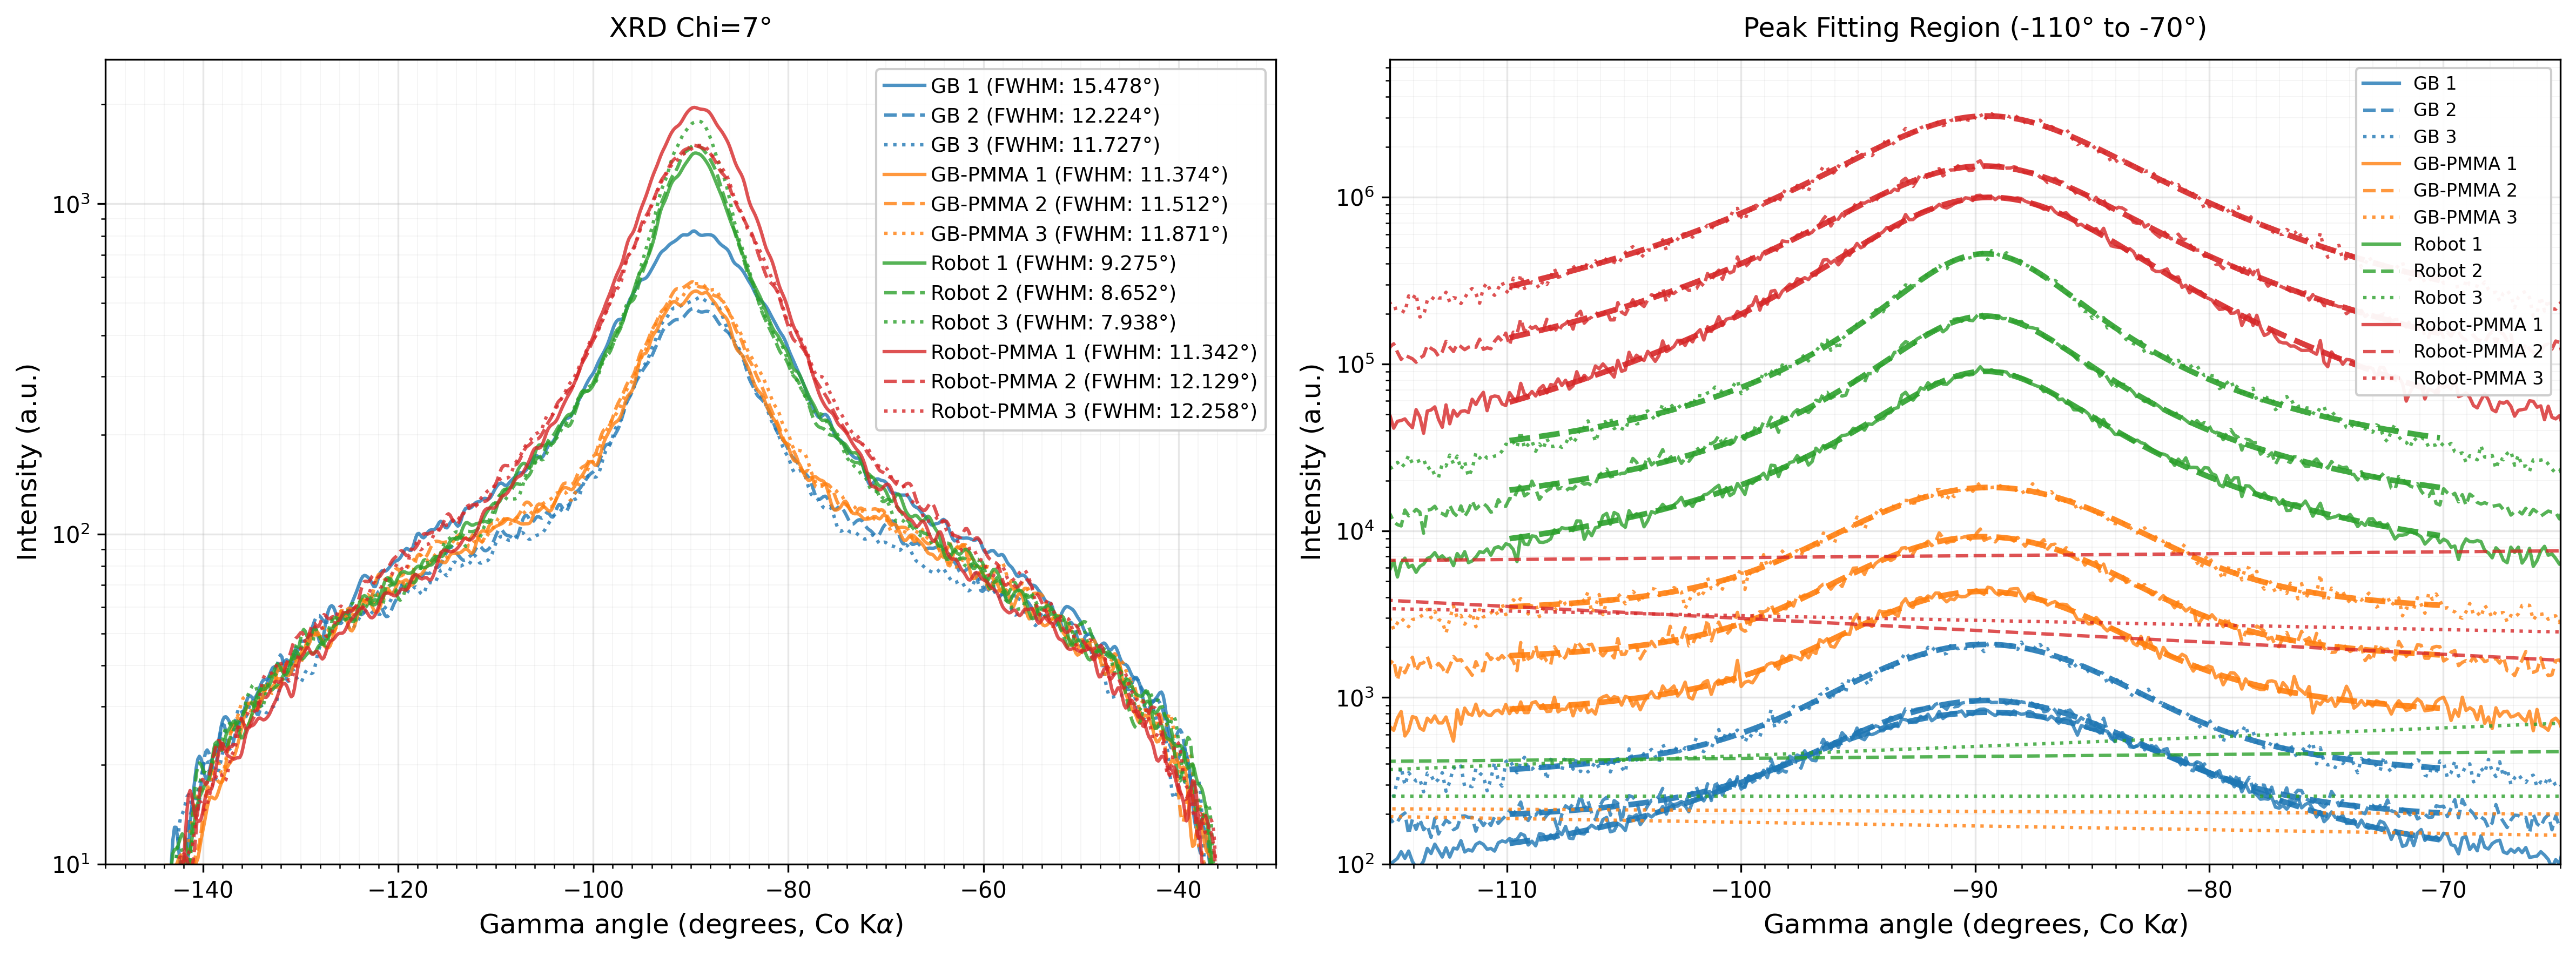

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Set data directory for the gamma_14 files
data_dir = Path(r"D:\XRD\20250902_rapha_cold")

# Find all the gamma_14.xy files
xy_files = list(data_dir.glob("**/S_MeO_pre4_*_gamma_6.xy"))

print(f"Found {len(xy_files)} files:")
for file in xy_files:
    print(f"  {file.name}")


def get_label_gamma14(filename):
    """Extract meaningful labels from gamma_14 filenames"""
    mapping = {
        "S_MeO_pre4_1_A01_gamma_6": "GB 1",
        "S_MeO_pre4_1_A02_gamma_6": "GB 2",
        "S_MeO_pre4_1_A03_gamma_6": "GB 3",
        "S_MeO_pre4_1_B01_gamma_6": "GB-PMMA 1",
        "S_MeO_pre4_1_B02_gamma_6": "GB-PMMA 2",
        "S_MeO_pre4_1_B03_gamma_6": "GB-PMMA 3",
        "S_MeO_pre4_2_A01_gamma_6": "Robot 1",
        "S_MeO_pre4_2_A02_gamma_6": "Robot 2",
        "S_MeO_pre4_2_A03_gamma_6": "Robot 3",
        "S_MeO_pre4_2_B01_gamma_6": "Robot-PMMA 1",
        "S_MeO_pre4_2_B02_gamma_6": "Robot-PMMA 2",
        "S_MeO_pre4_2_B03_gamma_6": "Robot-PMMA 3",
    }
    stem = filename.removesuffix("_gamma_6")
    try:
        return "int_" + mapping[filename.removeprefix("int_").removesuffix(".xy")]
    except KeyError:
        print(f"Warning: no label mapping for {filename}")
        return f"int_{stem}"


# Import helper functions
from plot_helper import get_linestyle_factory, get_color_factory

# Load and process data - no conversion needed for gamma scans
dfs = []
for xy_file in xy_files:
    gamma_col = f"gamma_{xy_file.stem}"
    int_col = f"int_{xy_file.stem}"

    # Read the gamma_14 data (use gamma angle directly)
    df = pd.read_csv(xy_file, sep="\t", header=None, names=[gamma_col, int_col])

    print(f"Processing {xy_file.name}")

    # Use gamma angle directly - no conversion needed
    df = df.set_index(gamma_col)

    # Filter reasonable gamma range
    df = df[(df.index > -150) & (df.index < 150)]  # Broader range for gamma scans

    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, axis=1)

print(df.columns)

# Apply labeling
df = df.rename(columns=get_label_gamma14)

print("Available columns:")
print(df.columns.tolist())

# Create the plot with improved layout
fig, (ax, ax_zoom) = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 6), dpi=300, layout="tight"
)

# Define which columns to plot (all gamma_14 data)
columns_to_plot = [
    "GB 1",
    "GB 2",
    "GB 3",
    "Robot 1",
    "Robot 2",
    "Robot 3",
    "GB-PMMA 1",
    "GB-PMMA 2",
    "GB-PMMA 3",
    "Robot-PMMA 1",
    "Robot-PMMA 2",
    "Robot-PMMA 3",
]

# Index offsets (if needed for alignment)
index_offsets = {
    "GB-PbI2 1 (γ=14°)": 0.0,
    "GB-PbI2 2 (γ=14°)": 0.0,
    "GB-PbI2 3 (γ=14°)": 0.0,
    "Robot-PbI2 1 (γ=14°)": 0.0,
    "Robot-PbI2 2 (γ=14°)": 0.0,
    "Robot-PbI2 3 (γ=14°)": 0.0,
}

# Filter intensity columns to plot
if columns_to_plot:
    intensity_cols = [
        col
        for col in sorted(df.columns)
        if col.startswith("int_") and col.removeprefix("int_") in columns_to_plot
    ]
else:
    intensity_cols = [col for col in sorted(df.columns) if col.startswith("int_")]

print("Plotting columns:")
print(intensity_cols)

# Peak fitting and FWHM analysis (before plotting to get FWHM for legend)
print("\n=== Peak Fitting Results ===")
peak_center_guess = (
    -90.0
)  # Expected gamma angle for the peak (center of -110 to -70 range)
fwhm_results = []
fit_results_full = {}  # Store full fit results for plotting

for intensity_col in intensity_cols:
    df_to_plot = df[[intensity_col]].dropna()
    x_data = df_to_plot.index.values + index_offsets.get(
        intensity_col.removeprefix("int_"), 0
    )
    y_data = df_to_plot[intensity_col].values

    # Fit peak and get FWHM
    result = fit_peak_fwhm(x_data, y_data, peak_center_guess)

    if result["success"]:
        sample_name = intensity_col.removeprefix("int_")
        fwhm_results.append(
            {
                "sample": sample_name,
                "fwhm": result["fwhm"],
                "center": result["center"],
                "r_squared": result["r_squared"],
            }
        )
        # Store full fit results for plotting
        fit_results_full[sample_name] = result
        print(
            f"{sample_name:30s} | FWHM: {result['fwhm']:.3f}° | Center: {result['center']:.2f}° | R²: {result['r_squared']:.4f}"
        )
    else:
        print(
            f"{intensity_col.removeprefix('int_'):30s} | Fit failed: {result['error']}"
        )

# Create FWHM lookup dictionary for legend labels and store fit results for visualization
fwhm_lookup = {r["sample"]: r["fwhm"] for r in fwhm_results}
fit_results_lookup = fit_results_full  # Use the full fit results

# Plot on both axes - revert to original color cycle
from plot_helper import get_linestyle_factory, get_color_factory

get_color = get_color_factory()
get_linestyle = get_linestyle_factory(ignore_out_of_range=True)

for i, intensity_col in enumerate(intensity_cols):
    df_to_plot = df[[intensity_col]].dropna()
    sample_name = intensity_col.removeprefix("int_")
    color = get_color(intensity_col)
    linestyle = get_linestyle(intensity_col)

    # Create label with FWHM if available
    if sample_name in fwhm_lookup:
        label = f"{sample_name} (FWHM: {fwhm_lookup[sample_name]:.3f}°)"
    else:
        label = f"{sample_name} (fit failed)"

    # Plot the original data on left plot (no fitting lines)
    ax.plot(
        df_to_plot.index + index_offsets.get(intensity_col.removeprefix("int_"), 0),
        gaussian_filter1d(df_to_plot[intensity_col], 2),
        label=label,
        linestyle=linestyle,
        color=color,
        linewidth=1.5,
        alpha=0.8,
    )

    # Plot data on right plot with offset for visibility
    ax_zoom.plot(
        df_to_plot.index + index_offsets.get(intensity_col.removeprefix("int_"), 0),
        df_to_plot[intensity_col] * (2**i),  # Offset for visibility
        label=sample_name,
        linestyle=linestyle,
        color=color,
        linewidth=1.5,
        alpha=0.8,
    )

    # Plot the Voigt fit ONLY on the zoom plot (right side)
    if sample_name in fit_results_lookup:
        fit_result = fit_results_lookup[sample_name]
        ax_zoom.plot(
            fit_result["x_fit"],
            fit_result["y_pred"] * (2**i),  # Offset for visibility
            "--",
            color=color,
            alpha=0.9,
            linewidth=2.5,
            label="fit",
        )

# Enhanced styling for both plots
from matplotlib.ticker import AutoMinorLocator

for axis in [ax, ax_zoom]:
    axis.set_yscale("log")
    axis.set_xlabel("Gamma angle (degrees, Co K$\\alpha$)", fontsize=12)
    axis.set_ylabel("Intensity (a.u.)", fontsize=12)
    axis.set_ylim(10, axis.get_ylim()[1])
    axis.minorticks_on()
    minor_locator = AutoMinorLocator(10)
    axis.xaxis.set_minor_locator(minor_locator)

    # Add grid for better readability
    axis.grid(True, which="major", alpha=0.3, linewidth=0.8)
    axis.grid(True, which="minor", alpha=0.15, linewidth=0.4)

    # Improve tick formatting
    axis.tick_params(labelsize=10)

ax.set_xlim(-150, -30)
# ax.set_ylim(100, None)

# Set specific limits and title for zoom plot (fitting region)
ax_zoom.set_xlim(-115, -65)
ax_zoom.set_title("Peak Fitting Region (-110° to -70°)", fontsize=12, pad=10)
ax_zoom.set_ylim(100, None)

# Add title to main plot
ax.set_title("XRD Chi=7°", fontsize=12, pad=10)

# Create improved legends with better organization
handles, labels = ax.get_legend_handles_labels()

# For the main plot (left), only show data with FWHM (no fit lines)
data_handles, data_labels = [], []

for handle, label in zip(handles, labels):
    if "fwhm" in label.lower():
        # Clean up labels for better readability
        clean_label = label.replace("GB-PbI2", "GB").replace("Robot-PbI2", "Robot")
        data_handles.append(handle)
        data_labels.append(clean_label)

# Create organized legend for main plot
ax.legend(
    data_handles,
    data_labels,
    loc="upper right",
    fontsize=9,
    framealpha=0.95,
    title_fontsize=10,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.3,
)

# Cleaner legend for zoom plot - only show sample names without FWHM
zoom_handles, zoom_labels = ax_zoom.get_legend_handles_labels()
zoom_data_handles, zoom_data_labels = [], []

for handle, label in zip(zoom_handles, zoom_labels):
    if "fit" not in label.lower():
        # Clean up the labels for zoom plot
        clean_label = label.split(" (")[0]  # Remove FWHM part
        clean_label = clean_label.replace("GB-PbI2", "GB").replace(
            "Robot-PbI2", "Robot"
        )
        zoom_data_handles.append(handle)
        zoom_data_labels.append(clean_label)

ax_zoom.legend(
    zoom_data_handles,
    zoom_data_labels,
    loc="upper right",
    fontsize=8,
    framealpha=0.95,
    title_fontsize=9,
)

# Set x-limits for full gamma range


# Summary statistics
if fwhm_results:
    fwhm_values = [r["fwhm"] for r in fwhm_results]
    center_values = [r["center"] for r in fwhm_results]
    print(f"\n=== Summary (n={len(fwhm_results)} successful fits) ===")
    print(f"FWHM range: {min(fwhm_values):.3f}° to {max(fwhm_values):.3f}°")
    print(f"Mean FWHM: {np.mean(fwhm_values):.3f}° ± {np.std(fwhm_values):.3f}°")
    print(f"Peak center range: {min(center_values):.2f}° to {max(center_values):.2f}°")
    print(
        f"Mean peak center: {np.mean(center_values):.2f}° ± {np.std(center_values):.2f}°"
    )

# Save the figure
fig.savefig(Path(data_dir, f"{data_dir.stem}-gamma6.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [102]:
import numpy as np
from pprint import pprint

temp_profile = np.zeros((8, 25 * 60))
temp_profile[(0, 1), 600 : 600 + 6 * 60] = np.linspace(0, 60, 6 * 60).astype(
    int
)  # ramp to 60C in 6 min
temp_profile[(0, 1), 600 + 6 * 60 :] = 60  # hold at 60C

with open("cold_annealing_ramp.txt", "w") as f:
    print(temp_profile.tolist(), file=f)